In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/NLP_VINAI/Lesson12/

/content/drive/MyDrive/NLP_VINAI/Lesson12


In [ ]:
# import package 
from pathlib import Path

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook

In [ ]:
# init device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
torch.manual_seed(22)

In [ ]:
#download the data
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

## Câu hỏi 1: Đọc dữ liệu 
- Hiển thị 5 samples trong dataframe
- pos là tập những review được đánh nhãn 1, hiển thị info của pos
- neg là tập những review được đánh nhãn 0, hiển thị info của neg

In [ ]:
df = pd.read_csv(DATA_PATH)
### YOUR CODE HERE ###
### YOUR CODE HERE ###

### YOUR CODE HERE ###

### YOUR CODE HERE ###

print(pos.info)
neg.info

<bound method DataFrame.info of                                                   review  label
12361  I went and saw this movie last night after bei...      1
12362  Actor turned director Bill Paxton follows up h...      1
12363  As a recreational golfer with some knowledge o...      1
12364  I saw this film in a sneak preview, and it is ...      1
12365  Bill Paxton has taken the true story of the 19...      1
...                                                  ...    ...
62146  To me, the final scene, in which Harris respon...      1
62147  While originally reluctant to jump on the band...      1
62148  I heard about this movie when watching VH1's \...      1
62149  I've never been huge on IMAX films. They're co...      1
62154  I saw this movie as a child and it broke my he...      1

[30870 rows x 2 columns]>


<bound method DataFrame.info of                                                   review  label
0      Once again Mr. Costner has dragged out a movie...      0
1      This is an example of why the majority of acti...      0
2      First of all I hate those moronic rappers, who...      0
3      Not even the Beatles could write songs everyon...      0
4      Brass pictures (movies is not a fitting word f...      0
...                                                  ...    ...
62143  What do you call a horror story without horror...      0
62150  I am a student of film, and have been for seve...      0
62151  Unimaginably stupid, redundant and humiliating...      0
62152  Guy is a loser. Can't get girls, needs to buil...      0
62153  This 30 minute documentary Buñuel made in the ...      0

[31285 rows x 2 columns]>

In [ ]:
df.head()
df['review'] = df['review'].str.lower()
df.head()

,review,label
0,once again mr. costner has dragged out a movie...,0
1,this is an example of why the majority of acti...,0
2,"first of all i hate those moronic rappers, who...",0
3,not even the beatles could write songs everyon...,0
4,brass pictures (movies is not a fitting word f...,0


## Câu hỏi 2: Xây dựng class Sequences, tiền xử lý dữ liệu, vector hóa text
- lower text, loại bỏ stopwords
- sử dụng BOW để vector hóa text

In [ ]:
class Sequences(Dataset):
    def __init__(self, path, max_seq_len):
        self.max_seq_len = max_seq_len
        df = pd.read_csv(path)
        ### YOUR CODE HERE ###

        ### YOUR CODE HERE ###

        vectorizer.fit(df.review.tolist())
        
        self.token2idx = vectorizer.vocabulary_
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1

        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.review.tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df.label.tolist()) if sequence])
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [ ]:
dataset = Sequences(DATA_PATH, max_seq_len=128)


In [ ]:
len(dataset.token2idx)


1104

In [ ]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])
    return inputs, target

batch_size = 2048
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate)

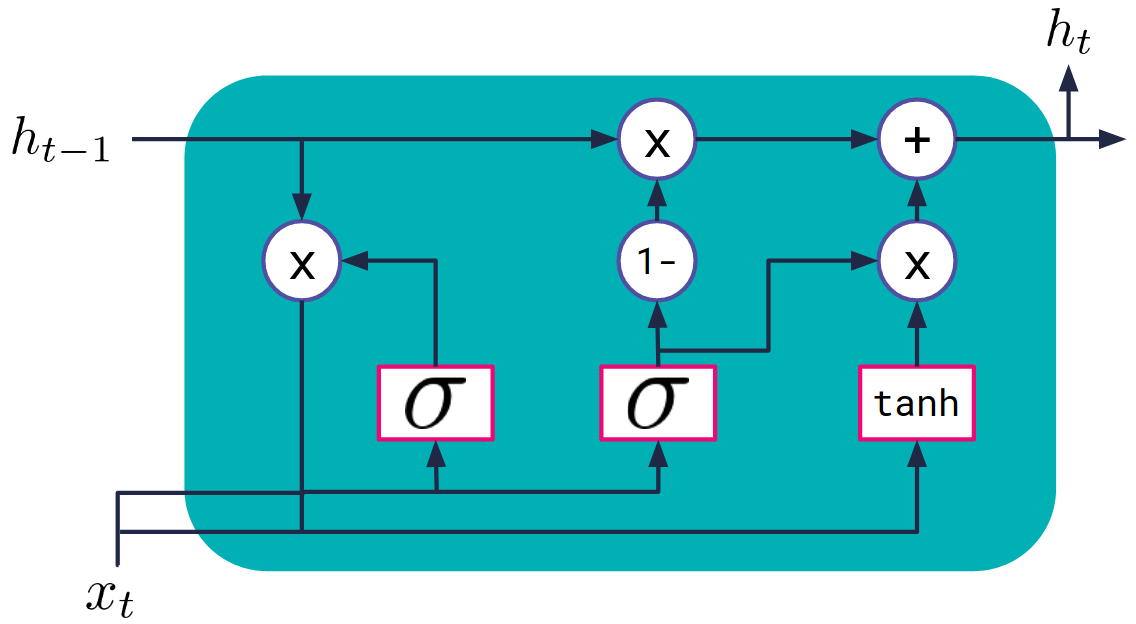

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/NLP_VINAI/Lesson12/image/gru_diagram.png')

## Câu hỏi 3 : Cấu hình GRU
Xây dựng Class RNN
- xây dựng hàm khởi tạo __init__() với 1 lớp encoder, 1 lớp GRU, 1 lớp decoder
    - Lớp encoder sử dụng nn.Embedding
    - Lớp GRU sử dụng nn.GRU
    - Lớp decoder sử dụng nn.Linear

In [ ]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        batch_size,
        embedding_dimension=100,
        hidden_size=128, 
        n_layers=1,
        device='cpu',
    ):
        super(RNN, self).__init__()
        ### YOUR CODE HERE ###

        ### YOUR CODE HERE ###
        
    def init_hidden(self):
        return torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)
    
    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        encoded = self.encoder(inputs)
        output, hidden = self.rnn(encoded, self.init_hidden())
        output = self.decoder(output[:, :, -1]).squeeze()
        return output

In [ ]:
# check cấu hình mạng
model = RNN(
    hidden_size=128,
    vocab_size=len(dataset.token2idx),
    device=device,
    batch_size=batch_size,
)
model = model.to(device)
model

RNN(
  (encoder): Embedding(1104, 100)
  (rnn): GRU(100, 128, batch_first=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

## Câu hỏi 4: Huấn luyện mô hình
- cấu hình hàm mất mát
- cấu hình hàm tối ưu

In [ ]:
### YOUR CODE HERE

### YOUR CODE HERE

In [ ]:
model.train()
train_losses = []
for epoch in range(30):
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        inputs, target = inputs.to(device), target.to(device
                                                     )
        model.zero_grad()
        
        output = model(inputs)
    
        loss = criterion(output, target)
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)

    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

## Câu hỏi 5 : Xây dựng hàm predict_sentiment
Threshold = 0.5

In [ ]:
### YOUR CODE HERE ###

### YOUR CODE HERE ###


In [ ]:
test_text = """
Cool Cat Saves The Kids is a symbolic masterpiece directed by Derek Savage that
is not only satirical in the way it makes fun of the media and politics, but in
the way in questions as how we humans live life and how society tells us to
live life.
"""
predict_sentiment(test_text)

0.998: Positive sentiment
